In [1]:
import os
import pytz

import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nfl_data_py as nfl

np.float_ = np.float64


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [2]:
years = range(2009, 2024)

In [3]:
for year in years:
    if not os.path.exists(f'../.cache/pbp/season={year}'):
        os.makedirs(f'../.cache/pbp/season={year}')
        nfl.cache_pbp(years=[year], alt_path='../.cache/pbp', downcast=True)

df_pbp = nfl.import_pbp_data(years, cache=True, alt_path='../.cache/pbp')

df_schedules = nfl.import_schedules(years).reset_index(drop=True)

df_stadiums_locs = pd.read_csv('../data/stadiums.csv')[['stadium_id','lat','lon','timezone']]

df_elevations = pd.read_csv('../data/stadium_elevation.csv')

2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [4]:
# Columns to keep
variables = [
    'season', 'game_id', 'play_id', 'play_type', 'desc', 'week', 'home_team', 'away_team', 'season_type', 'posteam',
    'posteam_type', 'defteam', 'game_half', 'game_seconds_remaining', 'score_differential',
    'posteam_score', 'defteam_score', 'drive_start_yard_line',
    'yardline_100', 'drive', 'down', 'ydstogo', 'yards_gained', 'posteam_timeouts_remaining',
    'defteam_timeouts_remaining', 'timeout', 'timeout_team', 'roof', 'surface', 'temp', 'wind',
    'home_coach', 'away_coach', 'stadium_id'
    
] # score_differential = posteam_score - defteam_score

# Sort by game_id and play_id and create columns for previous play's timeout and description
df_pbp = df_pbp.sort_values(['game_id', 'play_id'])
df_pbp['timeout_prev_play'] = df_pbp['timeout'].shift(1)
df_pbp['timeout_team_prev_play'] = df_pbp['timeout_team'].shift(1)
df_pbp['desc_prev_play'] = df_pbp['desc'].shift(1)

df = df_pbp.query('~play_type.isna()')[variables].copy()

# drop timeout plays
df = df.query('~((timeout==1) & posteam.isna())')

# Fix missing timeout team data for specific plays
fixes = {
    ('2013_07_SD_JAX', 2389.0): 'JAX',
    ('2015_09_JAX_NYJ', 2731.0): 'JAX'
}
for (game_id, play_id), team in fixes.items():
    df.loc[(df.play_id == play_id) & (df.game_id == game_id), 'timeout_team_prev_play'] = team

# Create binary columns for various conditions
df['overtime'] = (df['game_half'] == 'Overtime').astype(int)
df['postseason'] = (df['season_type'] == 'POST').astype(int)
df['home_stadium'] = (df['posteam_type'] == 'home').astype(int)
df['grass_surface'] = df['surface'].isin(['grass', 'grass ', 'dessograss']).astype(int)
df['outdoors'] = (df['roof'].isin(['outdoors', 'open'])).astype(int)

# Handle missing temperature and wind data
df['temp'] = df['temp'].fillna(70)
df['wind'] = df['wind'].fillna(0)

# Fill missing surface data based on the most common surface for each stadium
stadiums_with_surface = df.query('surface == ""').stadium_id.unique()
for stadium_id in stadiums_with_surface:
    v_counts = df.query('stadium_id == @stadium_id').surface.value_counts()
    surface = v_counts.index[0] 
    if (surface == "") & (len(v_counts) > 1):
        surface = v_counts.index[1]
    df.loc[(df.stadium_id == stadium_id) & (df.surface == ""), 'surface'] = surface

# Special case for a specific stadium
df.loc[df.stadium_id == "GER00", 'surface'] = "dessograss"

# Merge stadium elevations
df = df.merge(df_elevations, how='left', on='stadium_id')

df = df.merge(df_schedules[['game_id', 'gameday', 'gametime']], on='game_id', how='left')

df = df.merge(df_stadiums_locs, how='left', on='stadium_id')

# get pos teams home stadium elevation
home_stadiums = (df_schedules[['season', 'home_team', 'stadium_id']]
    .groupby(['season', 'home_team'])
    .agg(total=('stadium_id', 'count'), 
         home_stadium=('stadium_id', lambda x: x.value_counts().index[0]))
    .reset_index()
    .sort_values('total', ascending=True)
    [['season', 'home_team', 'home_stadium']]
    .merge(df_elevations, how='left', left_on='home_stadium', right_on='stadium_id')
    .drop(['stadium_id','home_stadium'], axis=1)
    .rename({'elevation':'home_stadium_elevation', 'home_team':'team'}, axis=1)
)
team_mapper = {
    'OAK': 'LV',
    'SD': 'LAC',
    'STL': 'LA'
}
home_stadiums['team'] = home_stadiums['team'].replace(team_mapper)
df = df.merge(home_stadiums, how='left', left_on=['season', 'posteam'], right_on=['season', 'team'])

df['elevation_diff'] = df['elevation'] - df['home_stadium_elevation']

# Convert start time to datetime and convert to local time
def convert_timezone(row):
    return row['start_time'].tz_convert(pytz.timezone(row['timezone']))
df['start_time'] = pd.to_datetime(df.gameday + ' ' + df.gametime, format='%Y-%m-%d %H:%M')
df['start_time'] = df['start_time'].dt.tz_localize(pytz.timezone('US/Eastern'))
df['start_time'] = df.apply(convert_timezone, axis=1)

# Drop unnecessary columns
drop_cols = []
df = df.drop(drop_cols, axis=1)

del df_pbp, df_stadiums_locs, df_elevations

In [5]:
df_weather = pd.read_pickle('../data/weather.pkl')

In [6]:
light_rain = [
    'Light Rain Fog/Mist', 'Light Freezing Rain', 'Light Rain', 'Light Rain And Windy', 
    'Thunderstorm Light Rain', 'Thunderstorm In Vicinity Light Rain Fog/Mist', 'Light Sleet', 
    'Drizzle And Humid', 'Light Rain And Breezy', 'Lt Rain', 'Lt Rain, Fog', 'Possible Light Rain', 
    'Possible Drizzle', 'Rain Fog/Mist', 'Mod Rain, Fog', 'Light Drizzle', 'Chance Showers', 'Thunder, Lt Rain',
    'Slight Chance Thunderstorms', 'Lt Rain', 'Drizzle'
]

rain = [
    'Rain Showers', 'Rain', 'Rain Fog/Mist And Breezy', 'Definite Rain', 'Rain And Windy', 
    'Rain And Humid', 'Heavy Rain Fog/Mist', 'Showers', 'Likely Rain', 'Thunderstorm Rain Fog/Mist',
    'Heavy Rain', 'Thunderstorms'
]

light_snow = [
    'Light Snow (< 1 In.)', 'Light Snow And Windy', 'Light Snow', 'Possible Light Snow', 
    'Light Snow Fog/Mist'
]

medium_snow = [
    'Snow And Breezy', 'Snow', 'Flurries', 'Possible Flurries', 'Wintry Mix'
]

heavy_snow = [
    'Heavy Snow', 'Blizzard', 'Heavy Snow Freezing Fog', 'Blowing Snow And Breezy'
]

In [7]:
# cap all of the visibility values at 10 max
df_weather['kickoff_visibility'] = np.where(df_weather['kickoff_visibility'] > 10, 10, df_weather['kickoff_visibility'])
df_weather['q2_visibility'] = np.where(df_weather['q2_visibility'] > 10, 10, df_weather['q2_visibility'])
df_weather['q3_visibility'] = np.where(df_weather['q3_visibility'] > 10, 10, df_weather['q3_visibility'])
df_weather['q4_visibility'] = np.where(df_weather['q4_visibility'] > 10, 10, df_weather['q4_visibility'])

In [8]:
# ordinal encode the weather, 0 if no rain, 1 if light rain, 2 if rain
df_weather['kickoff_rain'] = np.where(df_weather['kickoff_weather'].isin(light_rain), 1, 0)
df_weather['kickoff_rain'] = np.where(df_weather['kickoff_weather'].isin(rain), 2, df_weather['kickoff_rain'])
df_weather['kickoff_rain'] = np.where(df_weather['kickoff_weather'].isna(), None, df_weather['kickoff_rain'])

df_weather['q2_rain'] = np.where(df_weather['q2_weather'].isin(light_rain), 1, 0)
df_weather['q2_rain'] = np.where(df_weather['q2_weather'].isin(rain), 2, df_weather['q2_rain'])
df_weather['q2_rain'] = np.where(df_weather['q2_weather'].isna(), None, df_weather['q2_rain'])

df_weather['q3_rain'] = np.where(df_weather['q3_weather'].isin(light_rain), 1, 0)
df_weather['q3_rain'] = np.where(df_weather['q3_weather'].isin(rain), 2, df_weather['q3_rain'])
df_weather['q3_rain'] = np.where(df_weather['q3_weather'].isna(), None, df_weather['q3_rain'])

df_weather['q4_rain'] = np.where(df_weather['q4_weather'].isin(light_rain), 1, 0)
df_weather['q4_rain'] = np.where(df_weather['q4_weather'].isin(rain), 2, df_weather['q4_rain'])
df_weather['q4_rain'] = np.where(df_weather['q4_weather'].isna(), None, df_weather['q4_rain'])

In [9]:
# ordinal encode the snow weather by quarter, 0 if no snow, 1 if light snow, 2 if medium snow, 3 if heavy snow
df_weather['kickoff_snow'] = np.where(df_weather['kickoff_weather'].isin(light_snow), 1, 0)
df_weather['kickoff_snow'] = np.where(df_weather['kickoff_weather'].isin(medium_snow), 2, df_weather['kickoff_snow'])
df_weather['kickoff_snow'] = np.where(df_weather['kickoff_weather'].isin(heavy_snow), 3, df_weather['kickoff_snow'])
df_weather['kickoff_snow'] = np.where(df_weather['kickoff_weather'].isna(), None, df_weather['kickoff_snow'])

df_weather['q2_snow'] = np.where(df_weather['q2_weather'].isin(light_snow), 1, 0)
df_weather['q2_snow'] = np.where(df_weather['q2_weather'].isin(medium_snow), 2, df_weather['q2_snow'])
df_weather['q2_snow'] = np.where(df_weather['q2_weather'].isin(heavy_snow), 3, df_weather['q2_snow'])
df_weather['q2_snow'] = np.where(df_weather['q2_weather'].isna(), None, df_weather['q2_snow'])

df_weather['q3_snow'] = np.where(df_weather['q3_weather'].isin(light_snow), 1, 0)
df_weather['q3_snow'] = np.where(df_weather['q3_weather'].isin(medium_snow), 2, df_weather['q3_snow'])
df_weather['q3_snow'] = np.where(df_weather['q3_weather'].isin(heavy_snow), 3, df_weather['q3_snow'])
df_weather['q3_snow'] = np.where(df_weather['q3_weather'].isna(), None, df_weather['q3_snow'])

df_weather['q4_snow'] = np.where(df_weather['q4_weather'].isin(light_snow), 1, 0)
df_weather['q4_snow'] = np.where(df_weather['q4_weather'].isin(medium_snow), 2, df_weather['q4_snow'])
df_weather['q4_snow'] = np.where(df_weather['q4_weather'].isin(heavy_snow), 3, df_weather['q4_snow'])
df_weather['q4_snow'] = np.where(df_weather['q4_weather'].isna(), None, df_weather['q4_snow'])

In [10]:
# cols to merge: visibility, snow, rain
df_kickoff = df.copy()
df_q2 = df[(df.game_seconds_remaining <= 3*15*60) & (df.game_seconds_remaining > 2*15*60) & (df.overtime == 0)]
df_q3 = df[(df.game_seconds_remaining <= 2*15*60) & (df.game_seconds_remaining > 15*60) & (df.overtime == 0)]
df_q4_on = df[(df.game_seconds_remaining <= 15*60) | (df.overtime == 1)]

df_kickoff = df_kickoff.merge(df_weather[['game_id', 'kickoff_visibility', 'kickoff_snow', 'kickoff_rain']], on='game_id', how='left')
df_q2 = df_q2.merge(df_weather[['game_id', 'q2_visibility', 'q2_snow', 'q2_rain']], on='game_id', how='left')
df_q3 = df_q3.merge(df_weather[['game_id', 'q3_visibility', 'q3_snow', 'q3_rain']], on='game_id', how='left')
df_q4_on = df_q4_on.merge(df_weather[['game_id', 'q4_visibility', 'q4_snow', 'q4_rain']], on='game_id', how='left')

df.loc[df_q2.index, 'visibility'] = df_q2['q2_visibility']
df.loc[df_q3.index, 'visibility'] = df_q3['q3_visibility']
df.loc[df_q4_on.index, 'visibility'] = df_q4_on['q4_visibility']
df['visibility'] = np.where(df['visibility'].isna(), df_kickoff['kickoff_visibility'], df.visibility)
df['visibility'] = np.where(df['outdoors'] == 0, 10.0, df.visibility)

df.loc[df_q2.index, 'snow'] = df_q2['q2_snow']
df.loc[df_q3.index, 'snow'] = df_q3['q3_snow']
df.loc[df_q4_on.index, 'snow'] = df_q4_on['q4_snow']
df['snow'] = np.where(df['snow'].isna(), df_kickoff['kickoff_snow'], df.snow)
df['snow'] = np.where(df['outdoors'] == 0, 0, df.snow)

df.loc[df_q2.index, 'rain'] = df_q2['q2_rain']
df.loc[df_q3.index, 'rain'] = df_q3['q3_rain']
df.loc[df_q4_on.index, 'rain'] = df_q4_on['q4_rain']
df['rain'] = np.where(df['rain'].isna(), df_kickoff['kickoff_rain'], df.rain)
df['rain'] = np.where(df['outdoors'] == 0, 0, df.rain)

In [11]:
df.head()

,season,game_id,play_id,play_type,desc,week,home_team,away_team,season_type,posteam,posteam_type,defteam,game_half,game_seconds_remaining,score_differential,posteam_score,defteam_score,drive_start_yard_line,yardline_100,drive,down,ydstogo,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,timeout,timeout_team,roof,surface,temp,wind,home_coach,away_coach,stadium_id,timeout_team_prev_play,overtime,postseason,home_stadium,grass_surface,outdoors,elevation,gameday,gametime,lat,lon,timezone,team,home_stadium_elevation,elevation_diff,start_time,visibility,snow,rain
0,2009,2009_01_BUF_NE,56.0,kickoff,9-R.Lindell kicks 71 yards from BUF 30 to NE -...,1,NE,BUF,REG,NE,home,BUF,Half1,3600.0,0.0,0.0,0.0,BUF 49,30.0,1.0,NaN,0.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,BOS00,NaN,0,0,1,0,1,78,2009-09-14,19:00,42.087833,-71.258666,America/New_York,NE,78,0,2009-09-14 19:00:00-04:00,10.0,0,0
1,2009,2009_01_BUF_NE,79.0,pass,(14:52) 12-T.Brady pass incomplete short right...,1,NE,BUF,REG,NE,home,BUF,Half1,3592.0,0.0,0.0,0.0,BUF 49,49.0,1.0,1.0,10.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,BOS00,NaN,0,0,1,0,1,78,2009-09-14,19:00,42.087833,-71.258666,America/New_York,NE,78,0,2009-09-14 19:00:00-04:00,10.0,0,0
2,2009,2009_01_BUF_NE,101.0,run,(14:47) 21-F.Taylor right end to BUF 46 for 3 ...,1,NE,BUF,REG,NE,home,BUF,Half1,3587.0,0.0,0.0,0.0,BUF 49,49.0,1.0,2.0,10.0,3.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,BOS00,NaN,0,0,1,0,1,78,2009-09-14,19:00,42.087833,-71.258666,America/New_York,NE,78,0,2009-09-14 19:00:00-04:00,10.0,0,0
3,2009,2009_01_BUF_NE,122.0,pass,(14:03) (Shotgun) 12-T.Brady pass short middle...,1,NE,BUF,REG,NE,home,BUF,Half1,3543.0,0.0,0.0,0.0,BUF 49,46.0,1.0,3.0,7.0,6.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,BOS00,NaN,0,0,1,0,1,78,2009-09-14,19:00,42.087833,-71.258666,America/New_York,NE,78,0,2009-09-14 19:00:00-04:00,10.0,0,0
4,2009,2009_01_BUF_NE,146.0,run,(13:39) 77-N.Kaczur reported in as eligible. 3...,1,NE,BUF,REG,NE,home,BUF,Half1,3519.0,0.0,0.0,0.0,BUF 49,40.0,1.0,4.0,1.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,BOS00,NaN,0,0,1,0,1,78,2009-09-14,19:00,42.087833,-71.258666,America/New_York,NE,78,0,2009-09-14 19:00:00-04:00,10.0,0,0


# b. Impute missing "visibility" data with average value for it's weather condition group


In [12]:
clear_conditions = [
    'Fair', 'Sunny', 'Mostly Sunny', 'Clear', 'Mostly Clear', 'Na','°F'
]

cloudy_conditions = [
    'Mostly Cloudy', 'Partly Cloudy', 'Overcast', 'A Few Clouds', 'Few Clouds', 
    'Partly Sunny', 'Cloudy', 'Humid And Mostly Cloudy', 'Mostly Cloudy And Breezy',
    'Overcast With Haze', 'Overcast And Windy', 'Overcast And Breezy',
    'Partly Cloudy And Breezy', 'Partly Cloudy With Haze', 'Fair With Haze',
    'Humid And Overcast', 'Windy And Partly Cloudy', 'Windy And Overcast',
    'Dry And Partly Cloudy', 'Windy And Mostly Cloudy', 'Humid And Overcast',
    'A Few Clouds And Breezy', 'Decreasing Clouds', 'A Few Clouds With Haze',
    'Breezy And Mostly Cloudy', 'A Few Clouds And Breezy'
]

rainy_conditions = [
    'Light Rain', 'Rain', 'Rain Showers', 'Heavy Rain', 'Lt Rain', 'Lt Rain, Fog',
    'Light Drizzle', 'Thunderstorm Light Rain', 'Thunderstorm Rain Fog/Mist',
    'Heavy Rain Fog/Mist', 'Thunderstorm In Vicinity Light Rain Fog/Mist', 'Rain Fog/Mist',
    'Showers', 'Showers In Vicinity', 'Chance Showers', 'Mod Rain, Fog', 'Possible Drizzle',
    'Possible Light Rain', 'Light Rain And Breezy', 'Light Rain And Windy', 'Rain Fog/Mist And Breezy',
    'Light Freezing Rain', 'Humid And Partly Cloudy', 'Windy And Partly Cloudy', 'Fair And Breezy',
    'Possible Light Rain', 'Rain And Humid', 'Likely Rain', 'Chance Rain Showers',
    'Definite Rain', 'Slight Chance Thunderstorms', 'Heavy Rain Fog/Mist', 'Breezy And Humid',
    'Humid And Overcast', 'Rain And Windy', 'Blowing Snow And Breezy', 'Rain Showers',
    'Showers In Vicinity', 'Rain And Humid', 'Light Drizzle', 'Light Rain', 'Light Rain Fog/Mist',
    'Areas Drizzle', 'Drizzle', 'Drizzle And Humid', 'Thunderstorms'
]

snowy_conditions = [
    'Snow', 'Blizzard', 'Light Snow', 'Heavy Snow', 'Light Snow Fog/Mist', 'Snow And Breezy',
    'Heavy Snow Freezing Fog', 'Flurries', 'Possible Flurries', 'Light Sleet', 'Light Snow And Windy',
    'Snow And Breezy', 'Blowing Snow And Breezy', 'Light Snow (< 1 In.)', 'Possible Light Snow',
    'Wintry Mix', 'Sleet'
]

foggy_conditions = [
    'Fog/Mist', 'Overcast With Haze', 'Patchy Fog', 'Fog', 'Foggy', 'Humid', 'Humid And Mostly Cloudy',
    'Humid And Overcast', 'Areas Fog', 'Dry', 'Humid And Partly Cloudy', 'Windy And Partly Cloudy',
    'Fair With Haze', 'Fog', 'Dangerously Windy And Overcast', 'Shallow Fog' 
]

windy_conditions = [
    'Overcast And Windy', 'Overcast And Breezy', 'Windy And Partly Cloudy', 'Windy And Overcast',
    'Breezy', 'Breezy And Humid', 'Windy And Mostly Cloudy', 'Windy And Overcast', 'Windy And Partly Cloudy',
    'Windy And Overcast', 'Possible Light Rain And Windy', 'Humid And Overcast', 'Blowing Snow And Breezy',
    'Clear Windy'
]

mixed_conditions = [
    'Light Rain Fog/Mist', 'Rain Fog/Mist', 'Overcast With Haze', 'Thunderstorm Light Rain',
    'Thunderstorm Rain Fog/Mist', 'Light Drizzle', 'Fog/Mist', 'Light Snow Fog/Mist',
    'Thunderstorm In Vicinity Light Rain Fog/Mist', 'Rain Fog/Mist And Breezy', 'Rain And Humid',
    'Humid And Overcast', 'Rain Showers', 'Showers In Vicinity', 'Chance Thunderstorms', 'Thunder, Lt Rain',
    'Rain And Windy', 'Rain And Humid', 'Possible Drizzle', 'Possible Light Rain', 'Light Sleet',
    'Windy And Partly Cloudy', 'Windy And Overcast', 'Fair And Breezy', 'Humid And Mostly Cloudy'
]

# stack kickoff_weather, q2_weather, q3_weather, q4_weather together, then take the average visibility by each group of weather conditions
df_weather_conditions = df_weather[['game_id', 'kickoff_weather', 'q2_weather', 'q3_weather', 'q4_weather', 'kickoff_visibility', 'q2_visibility', 'q3_visibility', 'q4_visibility']]
df_weather_conditions = df_weather_conditions.melt(id_vars=['game_id', 'kickoff_visibility', 'q2_visibility', 'q3_visibility', 'q4_visibility'], value_vars=['kickoff_weather', 'q2_weather', 'q3_weather', 'q4_weather'], var_name='quarter', value_name='weather')
df_weather_conditions['weather'] = df_weather_conditions['weather'].str.strip()

df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(clear_conditions), 'clear', None)
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(cloudy_conditions), 'cloudy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(rainy_conditions), 'rainy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(snowy_conditions), 'snowy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(foggy_conditions), 'foggy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(windy_conditions), 'windy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(mixed_conditions), 'mixed', df_weather_conditions['weather_group'])

df_weather_conditions = df_weather_conditions.groupby(['weather_group']).agg(visibility=('kickoff_visibility', 'mean')).reset_index()
df_weather_conditions

,weather_group,visibility
0,clear,9.2951
1,cloudy,8.96366
2,foggy,4.600897
3,mixed,8.089202
4,rainy,6.876016
5,snowy,4.573333
6,windy,8.842105


In [13]:
# set weather group for kickoff
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(clear_conditions), 'clear', None)
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(cloudy_conditions), 'cloudy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(rainy_conditions), 'rainy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(snowy_conditions), 'snowy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(foggy_conditions), 'foggy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(windy_conditions), 'windy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(mixed_conditions), 'mixed', df_weather['kickoff_weather_group'])

# set weather group for q2
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(clear_conditions), 'clear', None)
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(cloudy_conditions), 'cloudy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(rainy_conditions), 'rainy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(snowy_conditions), 'snowy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(foggy_conditions), 'foggy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(windy_conditions), 'windy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(mixed_conditions), 'mixed', df_weather['q2_weather_group'])

# set weather group for q3
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(clear_conditions), 'clear', None)
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(cloudy_conditions), 'cloudy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(rainy_conditions), 'rainy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(snowy_conditions), 'snowy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(foggy_conditions), 'foggy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(windy_conditions), 'windy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(mixed_conditions), 'mixed', df_weather['q3_weather_group'])

# set weather group for q4
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(clear_conditions), 'clear', None)
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(cloudy_conditions), 'cloudy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(rainy_conditions), 'rainy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(snowy_conditions), 'snowy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(foggy_conditions), 'foggy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(windy_conditions), 'windy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(mixed_conditions), 'mixed', df_weather['q4_weather_group'])

# Copy and filter the field goal DataFrame for different quarters
df_kickoff = df.copy()
df_q2 = df[(df.game_seconds_remaining <= 3*15*60) & (df.game_seconds_remaining > 2*15*60) & (df.overtime == 0)]
df_q3 = df[(df.game_seconds_remaining <= 2*15*60) & (df.game_seconds_remaining > 15*60) & (df.overtime == 0)]
df_q4_on = df[(df.game_seconds_remaining <= 15*60) | (df.overtime == 1)]

# Merge weather data for each quarter
df_kickoff = df_kickoff.merge(df_weather[['game_id', 'kickoff_weather_group']], on='game_id', how='left')
df_q2 = df_q2.merge(df_weather[['game_id', 'q2_weather_group']], on='game_id', how='left')
df_q3 = df_q3.merge(df_weather[['game_id', 'q3_weather_group']], on='game_id', how='left')
df_q4_on = df_q4_on.merge(df_weather[['game_id', 'q4_weather_group']], on='game_id', how='left')

# Update the weather_group column in the original DataFrame
df.loc[df_q2.index, 'weather_group'] = df_q2['q2_weather_group']
df.loc[df_q3.index, 'weather_group'] = df_q3['q3_weather_group']
df.loc[df_q4_on.index, 'weather_group'] = df_q4_on['q4_weather_group']
df['weather_group'] = np.where(df['weather_group'].isna(), df_kickoff['kickoff_weather_group'], df.weather_group)
df['weather_group'] = np.where(df['outdoors'] == 0, 'indoors', df.weather_group)

In [14]:
# impute missing visibility data
df.loc[df.visibility.isna(), "visibility"] = df.loc[df.visibility.isna()].merge(df_weather_conditions, how='left', on='weather_group', suffixes=('','_new'))

In [15]:
df.drop(['weather_group'], axis=1, inplace=True)

In [16]:
cols = ['game_id', 'spread_line', 'home_score', 'away_score', 'home_qb_id', 'home_qb_name', 'away_qb_id', 'away_qb_name']
df = df.merge(df_schedules[cols], how='left', on='game_id')

In [17]:
df_schedules.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,2009_01_TEN_PIT,2009,REG,1,2009-09-10,Thursday,20:30,TEN,10.0,PIT,13.0,Home,3.0,23.0,1.0,2009091000,54467,NaN,200909100pit,1395.0,290910023,NaN,7,7,228.0,-260.0,6.5,-116.0,107.0,35.5,-106.0,-104.0,0,outdoors,dessograss,67.0,9.0,00-0003292,00-0022924,Kerry Collins,Ben Roethlisberger,Jeff Fisher,Mike Tomlin,Bill Leavy,PIT00,Heinz Field
1,2009_01_MIA_ATL,2009,REG,1,2009-09-13,Sunday,13:00,MIA,7.0,ATL,19.0,Home,12.0,26.0,0.0,2009091300,54468,NaN,200909130atl,1396.0,290913001,NaN,7,7,190.0,-210.0,4.0,-104.0,-104.0,44.0,-103.0,-107.0,0,dome,fieldturf,NaN,NaN,00-0019559,00-0026143,Chad Pennington,Matt Ryan,Tony Sparano,Mike Smith,Walt Coleman,ATL00,Georgia Dome
2,2009_01_KC_BAL,2009,REG,1,2009-09-13,Sunday,13:00,KC,24.0,BAL,38.0,Home,14.0,62.0,0.0,2009091301,54469,NaN,200909130rav,1398.0,290913033,NaN,7,7,570.0,-700.0,13.0,-112.0,104.0,36.5,-103.0,-107.0,0,outdoors,sportturf,76.0,5.0,00-0024300,00-0026158,Brodie Croyle,Joe Flacco,Todd Haley,John Harbaugh,Gene Steratore,BAL00,M&T Bank Stadium
3,2009_01_PHI_CAR,2009,REG,1,2009-09-13,Sunday,13:00,PHI,38.0,CAR,10.0,Home,-28.0,48.0,0.0,2009091302,54470,NaN,200909130car,1404.0,290913029,NaN,7,7,-125.0,115.0,-1.0,-120.0,111.0,43.5,-103.0,-107.0,0,outdoors,grass,82.0,5.0,00-0011022,00-0004161,Donovan McNabb,Jake Delhomme,Andy Reid,John Fox,Jeff Triplette,CAR00,Bank of America Stadium
4,2009_01_DEN_CIN,2009,REG,1,2009-09-13,Sunday,13:00,DEN,12.0,CIN,7.0,Home,-5.0,19.0,0.0,2009091303,54471,NaN,200909130cin,1403.0,290913004,NaN,7,7,196.0,-222.0,4.5,-104.0,-104.0,41.0,-112.0,102.0,0,outdoors,fieldturf,73.0,7.0,00-0023541,00-0021429,Kyle Orton,Carson Palmer,Josh McDaniels,Marvin Lewis,Jerome Boger,CIN00,Paul Brown Stadium


In [18]:
drop_cols = ['start_time','home_stadium_elevation','team','lat','lon','gametime','gameday','stadium_id']
df.drop(drop_cols, inplace=True, axis=1)

In [19]:
df.head()

,season,game_id,play_id,play_type,desc,week,home_team,away_team,season_type,posteam,posteam_type,defteam,game_half,game_seconds_remaining,score_differential,posteam_score,defteam_score,drive_start_yard_line,yardline_100,drive,down,ydstogo,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,timeout,timeout_team,roof,surface,temp,wind,home_coach,away_coach,timeout_team_prev_play,overtime,postseason,home_stadium,grass_surface,outdoors,elevation,timezone,elevation_diff,visibility,snow,rain,spread_line,home_score,away_score,home_qb_id,home_qb_name,away_qb_id,away_qb_name
0,2009,2009_01_BUF_NE,56.0,kickoff,9-R.Lindell kicks 71 yards from BUF 30 to NE -...,1,NE,BUF,REG,NE,home,BUF,Half1,3600.0,0.0,0.0,0.0,BUF 49,30.0,1.0,NaN,0.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards
1,2009,2009_01_BUF_NE,79.0,pass,(14:52) 12-T.Brady pass incomplete short right...,1,NE,BUF,REG,NE,home,BUF,Half1,3592.0,0.0,0.0,0.0,BUF 49,49.0,1.0,1.0,10.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards
2,2009,2009_01_BUF_NE,101.0,run,(14:47) 21-F.Taylor right end to BUF 46 for 3 ...,1,NE,BUF,REG,NE,home,BUF,Half1,3587.0,0.0,0.0,0.0,BUF 49,49.0,1.0,2.0,10.0,3.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards
3,2009,2009_01_BUF_NE,122.0,pass,(14:03) (Shotgun) 12-T.Brady pass short middle...,1,NE,BUF,REG,NE,home,BUF,Half1,3543.0,0.0,0.0,0.0,BUF 49,46.0,1.0,3.0,7.0,6.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards
4,2009,2009_01_BUF_NE,146.0,run,(13:39) 77-N.Kaczur reported in as eligible. 3...,1,NE,BUF,REG,NE,home,BUF,Half1,3519.0,0.0,0.0,0.0,BUF 49,40.0,1.0,4.0,1.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards


In [20]:
df['won'] = np.where(df.posteam==df.home_team, df.home_score > df.away_score, df.away_score > df.home_score).astype(int)
df['MoV'] = np.where(df.posteam==df.home_team, df.home_score - df.away_score, df.away_score - df.home_score) # Margin of Victory

In [21]:
qb_cols = ['player_display_name','player_id','position','season','week','season_type','passing_epa','rushing_epa']
roster_cols = ['player_id','season','years_exp','draft_number']
years = range(2006, 2024)

if not os.path.exists('../data/qb_epa.pkl'):
    df_qb = nfl.import_weekly_data(years, columns=qb_cols).query('(position=="QB")')

    # Merge draft number and years of experience
    df_player = nfl.import_seasonal_rosters(years,columns=roster_cols)
    df_qb = df_qb.merge(df_player, how='left', on=['player_id','season'])

    # Impute missing epa values
    df_qb.loc[:,['passing_epa','rushing_epa']] = df_qb.loc[:,['passing_epa','rushing_epa']].fillna(0, axis=1)

    # Impute missing draft numbers
    df_qb['draft_number'] = df_qb.draft_number.replace({None: np.nan}).astype(float)
    df_qb['draft_number'] = df_qb.groupby('player_id')['draft_number'].transform(lambda x: x.fillna(x.mean()))

    df_qb['draft_number'] = df_qb['draft_number'].fillna(300)

    df_qb.to_pickle('../data/qb_epa.pkl')
else:
    df_qb = pd.read_pickle('../data/qb_epa.pkl')

df_qb.head()

,player_display_name,player_id,position,season,week,season_type,passing_epa,rushing_epa,years_exp,draft_number
0,Charlie Batch,00-0000865,QB,2006,1,REG,10.850476,-7.552004,8.0,60.0
1,Charlie Batch,00-0000865,QB,2006,6,REG,-0.219950,0.000000,8.0,60.0
2,Charlie Batch,00-0000865,QB,2006,7,REG,11.705369,0.000000,8.0,60.0
3,Charlie Batch,00-0000865,QB,2006,12,REG,0.057769,0.000000,8.0,60.0
4,Charlie Batch,00-0000865,QB,2006,14,REG,0.000000,-3.291003,8.0,60.0


In [22]:
df_qb['total_epa'] = df_qb['passing_epa'] + df_qb['rushing_epa']

Mean Squared Error: 1988.383447131504
R^2: 0.03184867032894845
Coefficients: [ 0.00000000e+00  3.02308209e-03 -7.08718695e-02  5.41807526e-03
  1.45632356e-02  4.21759035e-05]


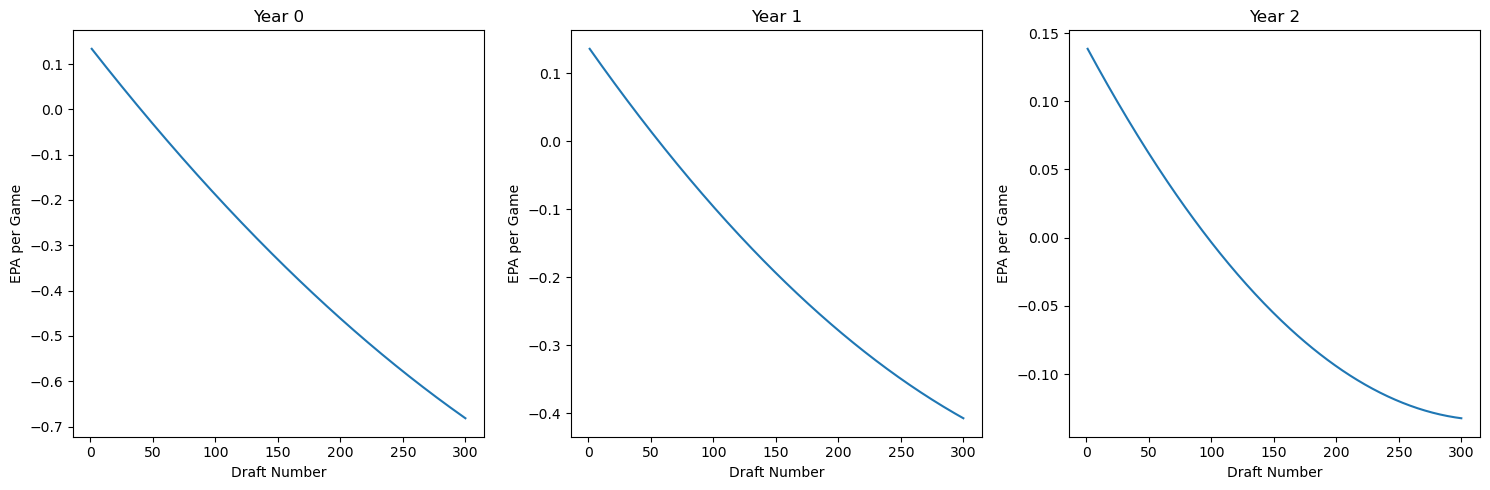

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_qb is already defined
df_early_career = df_qb.query('years_exp < 3').groupby(['player_display_name', 'player_id', 'years_exp', 'draft_number']).agg(total_epa=('total_epa', 'sum')).reset_index()

X = df_early_career[['years_exp', 'draft_number']]
y = df_early_career['total_epa']

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Apply Ridge regression
reg = Ridge(alpha=750000.0).fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))
print('Coefficients:', reg.coef_)

# Create df to predict total_epa for years 1, 2, 3 for every pick from 1 to 300
df_draft = pd.DataFrame({'years_exp': np.array([1] * 300 + [2]*300 + [3]*300), 'draft_number': np.array(list(range(1, 301)) * 3)})
X_draft_poly = poly.transform(df_draft[['years_exp', 'draft_number']])
df_draft['total_epa'] = reg.predict(X_draft_poly)
df_draft['epa_per_game'] = df_draft['total_epa'] / 16
df_draft['years_exp'] = df_draft['years_exp'] - 1
df_draft.drop('total_epa', axis=1, inplace=True)

# Plot the total_epa for each draft pick in three plots for each year of experience
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, year in enumerate([0, 1, 2]):
    sns.lineplot(data=df_draft.query(f'years_exp=={year}'), x='draft_number', y='epa_per_game', ax=ax[i])
    ax[i].set_title(f'Year {year}')
    ax[i].set_xlabel('Draft Number')
    ax[i].set_ylabel('EPA per Game')

plt.tight_layout()
plt.show()

In [24]:
df_draft_and_year = df_qb[['player_id','season','years_exp','draft_number']].copy()

In [25]:
df = df.merge(df_draft_and_year.rename({'player_id':'home_qb_id',
                                        'years_exp':'home_qb_years_exp',
                                        'draft_number':'home_qb_draft_number'}, axis=1),
              how='left', on=['home_qb_id', 'season'])

df = df.merge(df_draft.rename({'years_exp':'home_qb_years_exp',
                               'draft_number':'home_qb_draft_number',
                               'epa_per_game':'home_qb_epa_per_game'},axis=1), 
              how='left', on=['home_qb_years_exp', 'home_qb_draft_number'])

In [27]:
df = df.merge(df_draft_and_year.rename({'player_id':'away_qb_id',
                                        'years_exp':'away_qb_years_exp',
                                        'draft_number':'away_qb_draft_number'}, axis=1),
              how='left', on=['away_qb_id', 'season'])
df = df.merge(df_draft.rename({'years_exp':'away_qb_years_exp',
                               'draft_number':'away_qb_draft_number',
                              'epa_per_game':'away_qb_epa_per_game'},axis=1), 
              how='left', on=['away_qb_years_exp', 'away_qb_draft_number'])

KeyboardInterrupt: 

In [ ]:
df.rename({'home_qb_epa_per_game':'home_qb_default_epa_per_game',
           'away_qb_epa_per_game':'away_qb_default_epa_per_game'}, axis=1, inplace=True)

In [ ]:
q_25th_epa_per_game_gt_3_yr_exp = float(df_qb.query('years_exp >= 3').total_epa.quantile(0.46))

df['home_qb_default_epa_per_game'] = df['home_qb_default_epa_per_game'].fillna(q_25th_epa_per_game_gt_3_yr_exp)
df['away_qb_default_epa_per_game'] = df['away_qb_default_epa_per_game'].fillna(q_25th_epa_per_game_gt_3_yr_exp)

KeyError: 'away_qb_default_epa_per_game'

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd

# Enable tqdm for pandas
tqdm.pandas()

df_qb.sort_values(['player_id', 'season', 'week'], ascending=False, inplace=True)

total_epas = pd.DataFrame()

def get_epa_past_n_games(row, qb_id_col, default_epa_per_game_col, n=16):
    total_epas = df_qb[(df_qb.player_id == row[qb_id_col]) &
                       ((df_qb.season < row['season']) |
                        ((df_qb.season == row['season']) & (df_qb.week < row['week'])))].head(n)['total_epa']
    # Ensure default_epa_per_game is a float
    # Calculate the mean of the past n games' EPA and adjust for missing games
    return total_epas.mean() + (n - len(total_epas)) * row[default_epa_per_game_col]

def add_epa_past_n_games(df, n_list):
    df_home_qb = df.drop_duplicates(['game_id', 'home_qb_id'])[['game_id', 'season', 'week', 'home_qb_id', 'home_qb_default_epa_per_game']].copy()
    df_away_qb = df.drop_duplicates(['game_id', 'away_qb_id'])[['game_id', 'season', 'week', 'away_qb_id', 'away_qb_default_epa_per_game']].copy()

    for n in n_list:
        print(f'Calculating Home QB EPA for the past {n} games...')
        df_home_qb[f'home_qb_past_{n}_games'] = df_home_qb.progress_apply(get_epa_past_n_games, args=('home_qb_id', 'home_qb_default_epa_per_game', n), axis=1)
        print(f'Calculating Away QB EPA for the past {n} games...')
        df_away_qb[f'away_qb_past_{n}_games'] = df_away_qb.progress_apply(get_epa_past_n_games, args=('away_qb_id', 'away_qb_default_epa_per_game', n), axis=1)

        # if col is in df, drop
        for col in [f'home_qb_past_{n}_games', f'away_qb_past_{n}_games']:
            if col in df.columns:
                df.drop([col], axis=1, inplace=True)
        df = df.merge(df_home_qb[['game_id', f'home_qb_past_{n}_games']], how='left', on=['game_id'])
        df = df.merge(df_away_qb[['game_id', f'away_qb_past_{n}_games']], how='left', on=['game_id'])
    
    del df_home_qb, df_away_qb
    
    return df

df = add_epa_past_n_games(df, [16, 32, 40, 48])

Calculating Home QB EPA for the past 16 games...


  0%|          | 0/4060 [00:00<?, ?it/s]

Calculating Away QB EPA for the past 16 games...


  0%|          | 0/4060 [00:00<?, ?it/s]

Calculating Home QB EPA for the past 32 games...


  0%|          | 0/4060 [00:00<?, ?it/s]

Calculating Away QB EPA for the past 32 games...


  0%|          | 0/4060 [00:00<?, ?it/s]

Calculating Home QB EPA for the past 40 games...


  0%|          | 0/4060 [00:00<?, ?it/s]

Calculating Away QB EPA for the past 40 games...


  0%|          | 0/4060 [00:00<?, ?it/s]

Calculating Home QB EPA for the past 48 games...


  0%|          | 0/4060 [00:00<?, ?it/s]

Calculating Away QB EPA for the past 48 games...


  0%|          | 0/4060 [00:00<?, ?it/s]

In [ ]:
df.head()

,season,game_id,play_id,play_type,desc,week,home_team,away_team,season_type,posteam,posteam_type,defteam,game_half,game_seconds_remaining,score_differential,posteam_score,defteam_score,drive_start_yard_line,yardline_100,drive,down,ydstogo,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,timeout,timeout_team,roof,surface,temp,wind,home_coach,away_coach,timeout_team_prev_play,overtime,postseason,home_stadium,grass_surface,outdoors,elevation,timezone,elevation_diff,visibility,snow,rain,spread_line,home_score,away_score,home_qb_id,home_qb_name,away_qb_id,away_qb_name,won,MoV,home_qb_years_exp,home_qb_draft_number,home_qb_default_epa_per_game,away_qb_years_exp,away_qb_draft_number,away_qb_default_epa_per_game,home_qb_past_16_games,away_qb_past_16_games,home_qb_past_32_games,away_qb_past_32_games,home_qb_past_40_games,away_qb_past_40_games,home_qb_past_48_games,away_qb_past_48_games
0,2009,2009_01_BUF_NE,56.0,kickoff,9-R.Lindell kicks 71 yards from BUF 30 to NE -...,1,NE,BUF,REG,NE,home,BUF,Half1,3600.0,0.0,0.0,0.0,BUF 49,30.0,1.0,NaN,0.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards,1,1.0,9.0,199.0,0.045819,2.0,92.0,0.004257,12.474406,-0.385805,9.888268,-1.059626,9.135077,-1.025571,9.501625,-0.991516
1,2009,2009_01_BUF_NE,79.0,pass,(14:52) 12-T.Brady pass incomplete short right...,1,NE,BUF,REG,NE,home,BUF,Half1,3592.0,0.0,0.0,0.0,BUF 49,49.0,1.0,1.0,10.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards,1,1.0,9.0,199.0,0.045819,2.0,92.0,0.004257,12.474406,-0.385805,9.888268,-1.059626,9.135077,-1.025571,9.501625,-0.991516
2,2009,2009_01_BUF_NE,101.0,run,(14:47) 21-F.Taylor right end to BUF 46 for 3 ...,1,NE,BUF,REG,NE,home,BUF,Half1,3587.0,0.0,0.0,0.0,BUF 49,49.0,1.0,2.0,10.0,3.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards,1,1.0,9.0,199.0,0.045819,2.0,92.0,0.004257,12.474406,-0.385805,9.888268,-1.059626,9.135077,-1.025571,9.501625,-0.991516
3,2009,2009_01_BUF_NE,122.0,pass,(14:03) (Shotgun) 12-T.Brady pass short middle...,1,NE,BUF,REG,NE,home,BUF,Half1,3543.0,0.0,0.0,0.0,BUF 49,46.0,1.0,3.0,7.0,6.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards,1,1.0,9.0,199.0,0.045819,2.0,92.0,0.004257,12.474406,-0.385805,9.888268,-1.059626,9.135077,-1.025571,9.501625,-0.991516
4,2009,2009_01_BUF_NE,146.0,run,(13:39) 77-N.Kaczur reported in as eligible. 3...,1,NE,BUF,REG,NE,home,BUF,Half1,3519.0,0.0,0.0,0.0,BUF 49,40.0,1.0,4.0,1.0,0.0,3.0,3.0,0.0,None,outdoors,fieldturf,70.0,5.0,Bill Belichick,Dick Jauron,NaN,0,0,1,0,1,78,America/New_York,0,10.0,0,0,13.5,25.0,24.0,00-0019596,Tom Brady,00-0025479,Trent Edwards,1,1.0,9.0,199.0,0.045819,2.0,92.0,0.004257,12.474406,-0.385805,9.888268,-1.059626,9.135077,-1.025571,9.501625,-0.991516


In [ ]:
# print the top 10 qb performances by home_qb_past_16_games (drop duplicate qbs), away_qb_past_16_games, home_qb_past_32_games, away_qb_past_32_games, home_qb_past_40_games, away_qb_past_40_games, home_qb_past_48_games, away_qb_past_48_games
df_qb_past_16 = df.sort_values('home_qb_past_16_games', ascending=False).drop_duplicates(['home_qb_id'])[['game_id', 'home_qb_name', 'home_qb_past_16_games']].head(10)
df_qb_past_16['home_qb_past_16_games'] = df_qb_past_16['home_qb_past_16_games'].round(2)
df_qb_past_32 = df.sort_values('home_qb_past_32_games', ascending=False).drop_duplicates(['home_qb_id'])[['game_id', 'home_qb_name', 'home_qb_past_32_games']].head(10)
df_qb_past_32['home_qb_past_32_games'] = df_qb_past_32['home_qb_past_32_games'].round(2)
df_qb_past_40 = df.sort_values('home_qb_past_40_games', ascending=False).drop_duplicates(['home_qb_id'])[['game_id', 'home_qb_name', 'home_qb_past_40_games']].head(10)
df_qb_past_40['home_qb_past_40_games'] = df_qb_past_40['home_qb_past_40_games'].round(2)
df_qb_past_48 = df.sort_values('home_qb_past_48_games', ascending=False).drop_duplicates(['home_qb_id'])[['game_id', 'home_qb_name', 'home_qb_past_48_games']].head(10)
df_qb_past_48['home_qb_past_48_games'] = df_qb_past_48['home_qb_past_48_games'].round(2)

print('Top 10 QB Performances by EPA per Game in the Past 16 Games:')
print(df_qb_past_16)
print('\nTop 10 QB Performances by EPA per Game in the Past 32 Games:')
print(df_qb_past_32)
print('\nTop 10 QB Performances by EPA per Game in the Past 40 Games:')
print(df_qb_past_40)
print('\nTop 10 QB Performances by EPA per Game in the Past 48 Games:')
print(df_qb_past_48)

del df_qb_past_16, df_qb_past_32, df_qb_past_40, df_qb_past_48

Top 10 QB Performances by EPA per Game in the Past 16 Games:
                game_id     home_qb_name  home_qb_past_16_games
405697    2018_03_SF_KC  Patrick Mahomes                  18.11
120650   2011_14_OAK_GB    Aaron Rodgers                  15.20
18496    2009_08_SF_IND   Peyton Manning                  14.80
136746  2012_03_CIN_WAS   Robert Griffin                  14.65
152743   2012_09_PHI_NO       Drew Brees                  14.31
90578    2011_02_GB_CAR       Cam Newton                  14.10
168128    2012_15_SF_NE        Tom Brady                  13.92
595048   2022_08_GB_BUF       Josh Allen                  12.38
485070  2019_19_TEN_BAL    Lamar Jackson                  12.22
68028    2010_11_DEN_SD    Philip Rivers                  12.12

Top 10 QB Performances by EPA per Game in the Past 32 Games:
                game_id     home_qb_name  home_qb_past_32_games
405783    2018_03_SF_KC  Patrick Mahomes                  19.97
136796  2012_03_CIN_WAS   Robert Griffin     

MovieWriter imagemagick unavailable; using Pillow instead.


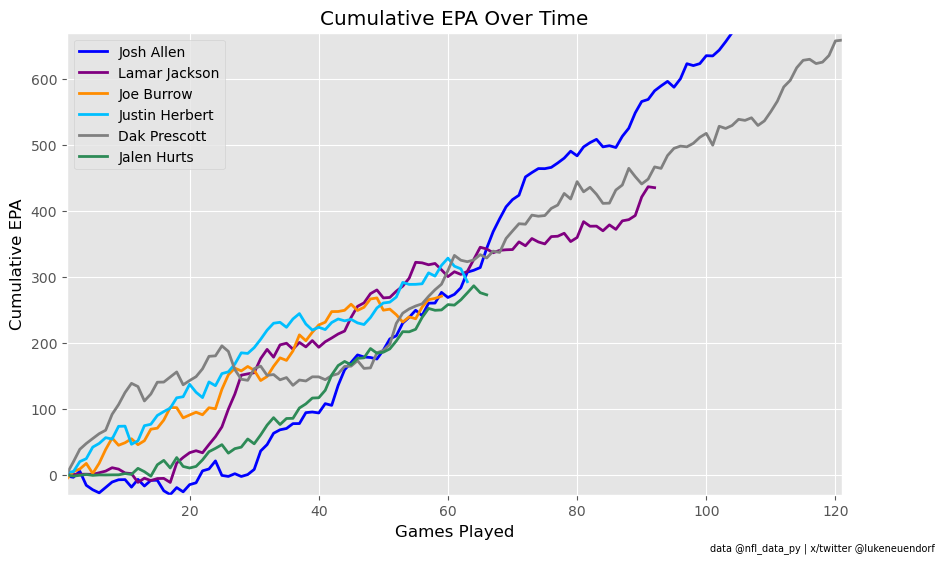

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Use ggplot style
plt.style.use('ggplot')

# update fig size
plt.rcParams['figure.figsize'] = [10, 6]

# List of players to include in the plot
players = ['Patrick Mahomes', 'Josh Allen', 'Lamar Jackson', 'Joe Burrow', 'Justin Herbert', 'Dak Prescott', 'Jalen Hurts']

players = ['Josh Allen', 'Lamar Jackson', 'Joe Burrow', 'Justin Herbert', 'Dak Prescott', 'Jalen Hurts']

# Dictionary of custom colors for each player
# player_colors = {
    # 'Patrick Mahomes': '#E31837',
player_colors = {
    'Josh Allen': 'blue',
    'Lamar Jackson': 'purple',
    'Joe Burrow': 'darkorange',
    'Justin Herbert': 'deepskyblue',
    'Dak Prescott': 'grey',
    'Jalen Hurts': 'seagreen'
}

# Initialize a dictionary to store data for each player
player_data = {}

for player in players:
    # Filter data for the current player
    df_player = df_qb[df_qb['player_display_name'] == player]

    # Sort by season and week
    df_player = df_player.sort_values(by=['season', 'week'], ignore_index=True)

    # Add games played column
    df_player['games_played'] = df_player.index + 1

    # Calculate the cumulative EPA
    df_player['cumulative_epa'] = df_player['total_epa'].cumsum()

    # Store the processed data in the dictionary
    player_data[player] = df_player

# Plotting and creating the GIF
fig, ax = plt.subplots()
ax.set_xlim(1, max(df['games_played'].max() for df in player_data.values()))
ax.set_ylim(min(df['cumulative_epa'].min() for df in player_data.values()),
            max(df['cumulative_epa'].max() for df in player_data.values()))
ax.set_xlabel('Games Played', color='black')
ax.set_ylabel('Cumulative EPA', color='black')
ax.set_title('Cumulative EPA Over Time', color='black')

# Initialize a dictionary to store lines for each player
lines = {}

# Create a line for each player with the specified color
for player in players:
    line, = ax.plot([], [], color=player_colors[player], lw=2, label=player)
    lines[player] = line

# Initialize the plot with empty data
def init():
    for line in lines.values():
        line.set_data([], [])
    return list(lines.values())

# Update function for the animation
def update(frame):
    for player in players:
        week_data = player_data[player].iloc[:frame+1]
        lines[player].set_data(week_data['games_played'], week_data['cumulative_epa'])
    return list(lines.values())

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(max(player_data.values(), key=len)), init_func=init, blit=True, repeat=False
)

# Add a legend
ax.legend(loc='upper left')

# add this line to the bottom right of the image "data @nfl_data_py | x/twitter @lukeneuendorf"
ax.text(1.12, -0.12, 'data @nfl_data_py | x/twitter @lukeneuendorf', transform=ax.transAxes, ha='right', color='black', fontsize=7)

# Save as GIF
ani.save('cumulative_epa_comparison_custom_colors.gif', writer='imagemagick')

plt.show()